# LFP power center of mass
### Compute center of mass in power in theta band throughout the trial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy import ndimage
from scipy import stats 

import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
import pickle

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

In [3]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

In [282]:
freqs = np.logspace(*np.log10([4, 12]), num=30) # define frequencies of interest (log-spaced)
n_cycles = freqs / 2.  # different number of cycle per frequency
output = 'power'
wind_size = 100


trial_begin           = 0
trial_end             = 2500
filter_data_low_freq  = 4
filter_data_high_freq = 48
smooth_psd_sz         = 15
smooth_psd_sigma      = 2

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]

log_com_freq = []
for sub in range(len(sessions)):


    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    idx_trials = trials_markers[sessions[sub]]

    
    cc = hpc_electrodes[sub][0]

    
    lfp[cc] = mne.filter.notch_filter( np.float64(lfp[cc]), fs, [50,100,150,200], notch_widths=20 )    
    lfp[cc] = mne.filter.filter_data(np.float64(lfp[cc]), fs, 2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin' )
    
    
    all_pow_com = []
    for trial in range(len(idx_trials)):

        tmp_lfp = lfp[cc][ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
#         tmp_lfp_bbp = mne.filter.filter_data(  np.float64(tmp_lfp) , fs, filter_data_low_freq, filter_data_high_freq)

        power = mne.time_frequency.tfr_array_morlet( [[tmp_lfp]],  fs, freqs=freqs, output=output )
        power = power[0,0]
        
        power = stats.zscore(power,axis=0)


        pow_com = []        
        for w in range(power.shape[1] - wind_size):
#             pow_com.append( ndimage.measurements.center_of_mass( power[:,w:w+wind_size] )[0] )

            ### Get back from 2d array Y index to frequency domain
#             iii = ndimage.measurements.center_of_mass( power[:,w:w+wind_size] )[0]
            iii = ndimage.measurements.center_of_mass( power[:,w:w+wind_size]+np.abs(power[:,w:w+wind_size].min()) )[0]
#             pow_com.append( freqs[int(iii)] )
            
        cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
        csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
            
        all_pow_com.append( [cc, tmp_density[trial], tmp_speed[trial], cs, csw, pow_com] )
    
    log_com_freq.append(all_pow_com)

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 sam

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected


Text(0.5, 0, 'Time (sec)')

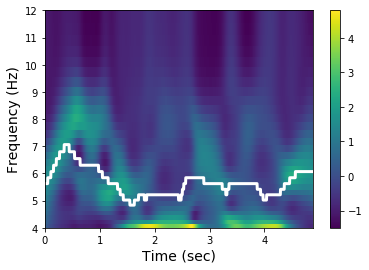

In [293]:
sub = 1

lfp = loadmat('../Data/'+sessions[sub]+'.mat')
lfp = lfp['ourData']
idx_trials = trials_markers[sessions[sub]]


cc = hpc_electrodes[sub][0]

trial = 4


lfp[cc] = mne.filter.notch_filter( np.float64(lfp[cc]), fs, [50,100,150,200], notch_widths=20 )    
lfp[cc] = mne.filter.filter_data(np.float64(lfp[cc]), fs, 2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin' )


tmp_lfp = lfp[cc][ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
# tmp_lfp_bbp = mne.filter.filter_data(  np.float64(tmp_lfp) , fs, filter_data_low_freq, filter_data_high_freq)

power = mne.time_frequency.tfr_array_morlet( [[tmp_lfp]],  fs, freqs=freqs, output=output  )
power = power[0,0]

power = stats.zscore(power,axis=0)

times = np.linspace(0, power.shape[1]/fs, power.shape[1])

plt.pcolormesh(times,freqs, power)
plt.colorbar()

pow_com = []        
for w in range(power.shape[1] ):
#     pow_com.append( ndimage.measurements.center_of_mass( power[:,w:w+wind_size] )[0] )
#     iii = ndimage.measurements.center_of_mass( power[:,w:w+wind_size] )[0]
    iii = ndimage.measurements.center_of_mass( power[:,w:w+wind_size]+np.abs(power[:,w:w+wind_size].min()) )[0]
#     pow_com.append( freqs[int(iii)] )
    pow_com.append( iii )
            

pow_com = np.array(pow_com)

plt.plot(times, freqs[pow_com.astype(int)] , color='w', linewidth=3)


plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (sec)', fontsize=14)


In [294]:
frq_com = []
for ss in range(8):
    for tt in range(len(log_com_freq[sub])):
        
        tmp = np.array(log_com_freq[ss][tt][5])
        num_bins = 30
        pha_hist = np.histogram(freqs[tmp.astype(int)], bins=int(num_bins))
        phase_dist = pha_hist[0] + 1
        n_pevents = float(np.sum(phase_dist))
        ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
        K_L = (np.log(num_bins) - ppp) / np.log(num_bins)
        

        frq_com.append( [ sub, log_com_freq[ss][tt][1] , log_com_freq[ss][tt][2] , log_com_freq[ss][tt][3], log_com_freq[ss][tt][4], np.mean(log_com_freq[ss][tt][5]), np.var(log_com_freq[ss][tt][5]), K_L ] )
        
frq_com = np.array(frq_com)
frq_com = pd.DataFrame(frq_com, columns=['sub','density','speed','cuesec', 'cuesec_w','freq_com_mean','freq_com_std','freq_com_KL'] )



                 sum_sq     df         F    PR(>F)
freq_com_KL    0.373754    1.0  0.556885  0.456337
Residual     143.626246  214.0       NaN       NaN
                 sum_sq     df         F    PR(>F)
freq_com_KL    0.301443    1.0  0.448917  0.503572
Residual     143.698557  214.0       NaN       NaN


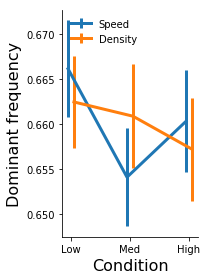

In [299]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)

var_of_interst = 'freq_com_KL'


mmd = frq_com.groupby(['density']).mean()[var_of_interst]
mms = frq_com.groupby(['speed']).mean()[var_of_interst]

ssd = frq_com.groupby(['density']).sem()[var_of_interst]
sss = frq_com.groupby(['speed']).sem()[var_of_interst]

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='upper left')

plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])

plt.tight_layout()
# plt.savefig('../Figures/theta_dominant_freq_both.pdf')


cw_lm=ols('speed ~ ' + var_of_interst , data=frq_com).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
cw_lm=ols('density ~ ' + var_of_interst , data=frq_com).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))


Pearson:  (-0.0547586634171941, 0.42329611882509743)
                sum_sq     df         F    PR(>F)
freq_com_KL    0.28729    1.0  0.320689  0.571787
Residual     191.71271  214.0       NaN       NaN


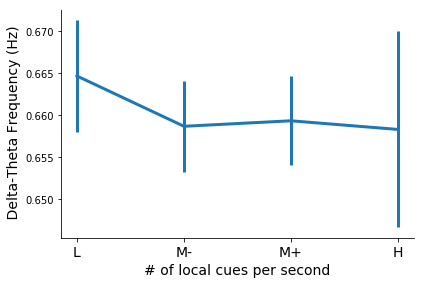

In [300]:
mmcs = frq_com.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = frq_com.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)


ax.errorbar( range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)

# plt.ylim(8,12)

plt.tight_layout()

plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )


print( 'Pearson: ',  stats.pearsonr(frq_com.cuesec, frq_com[var_of_interst] ))

cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=frq_com).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')

In [170]:
real_control = 'control'


all_control = []


for iix in range(100):

    save_freq_in_cs =[]
    for cs in frq_com.cuesec.unique():
        idx = np.where( frq_com.cuesec==cs )[0]
        if real_control == 'control':
            idx = np.random.randint( 0, frq_com.shape[0], idx.size  )
        save_freq_in_cs.append( frq_com[var_of_interst][idx] )





    if real_control == 'real':
        rmm,rss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            rmm.append(np.mean(save_freq_in_cs[ii]))
            rss.append(stats.sem(save_freq_in_cs[ii]))

    if real_control == 'control':
        control_mm,control_ss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            control_mm.append(np.mean(save_freq_in_cs[ii]))
            control_ss.append(stats.sem(save_freq_in_cs[ii]))

        all_control.append(control_mm)
        
all_control = np.array(all_control)




control_m = np.mean(all_control,axis=0)
control_s = stats.sem(all_control,axis=0)


Pearson:  (0.04268381437290061, 0.5326500360117404)
                    sum_sq     df       F   PR(>F)
freq_com_mean     4.508744    1.0  0.3906  0.53265
Residual       2470.228552  214.0     NaN      NaN


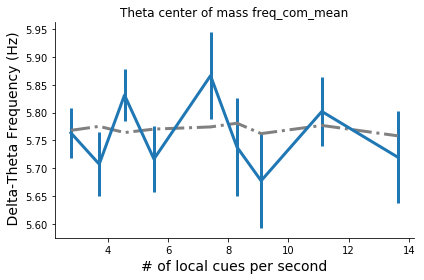

In [171]:
mmcs = frq_com.groupby(['cuesec']).median()[var_of_interst]
sscs = frq_com.groupby(['cuesec']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)



plt.plot(uni, control_m, linestyle='-.', color='grey', linewidth=3 )

ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3  )
# plt.plot( uni, mmcs)
# plt.fill_between( uni, mmcs-sscs, mmcs+sscs,alpha=0.2 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)



plt.title('Theta center of mass ' + var_of_interst)

# plt.ylim(9,11)

plt.tight_layout()



print( 'Pearson: ',  stats.pearsonr(frq_com.cuesec, frq_com[var_of_interst] ))

cw_lm=ols('cuesec ~ ' + var_of_interst , data=frq_com).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')